### Genes with RP

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from scipy.stats import mannwhitneyu
import scipy.stats as stats
from collections import Counter
from matplotlib.lines import Line2D

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

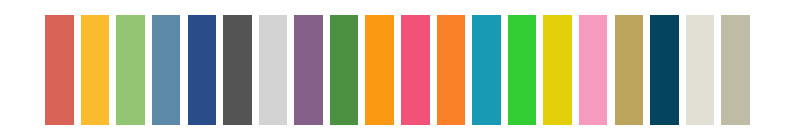

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [3]:
# load ella results
fn = '../ella/output_ella/ella_stereoseq_t1t20.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

In [4]:
# check the labels of a gene list
def check_label(t, gl):
    gl_t = np.array(genes_dict[t])
    lab_t = label_dict[t]
    gl_lab = []
    for g in gl:
        if g in gl_t:
            ig = np.where(gl_t == g)[0][0]
            gl_lab.append(lab_t[ig])
        else:
            gl_lab.append(-2)

    return gl_lab

In [5]:
##### find rp in each type
# rp genes tested 
# begin with rps or rpl
rp_dict = {}
rp_label_dict = {}
n_rp = []
for t in types_list:
    gl_t = genes_dict[t]
    rp_list = []
    for g in gl_t:
        if g.startswith('Rps') or g.startswith('Rpl'):
            rp_list.append(g)
    rp_dict[t] = rp_list
    rp_label_dict[t] = check_label(t, rp_list)
    n_rp.append(len(rp_list))

In [6]:
print(f'#rp avg={np.mean(n_rp)} median={np.median(n_rp)} min={np.min(n_rp)} max={np.max(n_rp)}')      

print(f'#rp in 1 {n_rp[0]}')
print(f'labels for 1 {Counter(rp_label_dict["1"])}')

print(f'#rp in 20 {n_rp[1]}')
print(f'labels for 20 {Counter(rp_label_dict["20"])}')

#rp avg=84.5 median=84.5 min=84 max=85
#rp in 1 84
labels for 1 Counter({-1: 79, 4: 5})
#rp in 20 85
labels for 20 Counter({-1: 78, 4: 7})


In [7]:
##### get the counts for pie plot
K_opt = 5
nsig_nonrp_dict = {}
nsig_rp_dict = {}
nsigrp_ = []

for t in types_list:
    nsig_nonrp = np.zeros(K_opt)
    nsig_rp = np.zeros(K_opt)
    
    label_t = np.array(label_dict[t])
    rp_label_t = np.array(rp_label_dict[t])
    rp_t = np.array(rp_dict[t])
    
    for j in range(K_opt):
        nsig_total_j = np.sum(label_t==j)
        nsig_rp_j = np.sum(rp_label_t==j)
        nsig_nonrp[j] = nsig_total_j - nsig_rp_j
        nsig_rp[j] = nsig_rp_j

    nsig_nonrp_dict[t] = nsig_nonrp
    nsig_rp_dict[t] = nsig_rp

    nsigrp_.append(np.sum(nsig_rp))

In [8]:
print(np.mean(nsigrp_))
print(np.median(nsigrp_))
print(np.min(nsigrp_))
print(np.max(nsigrp_))

6.0
6.0
5.0
7.0


#### all types together

In [14]:
# cluster 3-4 vs 0-2
rp_label_all = np.concatenate([lst for lst in rp_label_dict.values()])
label_all = np.concatenate([lst for lst in label_dict.values()])

# number of sig tf with label=
n11 = np.sum((rp_label_all==3)|(rp_label_all==4))
# number of sig tf with label=
n12 = np.sum((rp_label_all==0)|(rp_label_all==1)|(rp_label_all==2))
# number of sig non-tf with label=
n21 = np.sum((label_all==3)|(label_all==4)) - n11
# number of sig non-tf with label=
n22 = np.sum((label_all==0)|(label_all==1)|(label_all==2)) - n12

#       label=     label=
data = [[n11,      n12], # RP
        [n21,      n22]] # non-RP

# fisher test
odd_ratio, p_value1 = stats.fisher_exact(data)
print(f'p={p_value1}')
print(f'3-4 RP={n11/(n11+n21)*100:.2f}%')
print(f'0-2 RP={n12/(n12+n22)*100:.2f}%')

p21 = [p_value1]

p=2.9048408269544155e-07
3-4 RP=7.23%
0-2 RP=0.00%


In [15]:
# all types together
# cluster 0-2 vs all others
rp_label_all = np.concatenate([lst for lst in rp_label_dict.values()])
label_all = np.concatenate([lst for lst in label_dict.values()])

# number of sig tf with label=
n11 = np.sum((rp_label_all==3)|(rp_label_all==4))
# number of sig tf with label=
n12 = np.sum((rp_label_all==0)|(rp_label_all==1)|(rp_label_all==2)|(rp_label_all==-1))
# number of sig non-tf with label=
n21 = np.sum((label_all==3)|(label_all==4)) - n11
# number of sig non-tf with label=
n22 = np.sum((label_all==0)|(label_all==1)|(label_all==2)|(label_all==-1)) - n12

#       label=     label=
data = [[n11,      n12], # RP
        [n21,      n22]] # non-RP

# fisher test
odd_ratio, p_value2 = stats.fisher_exact(data)
print(f'p={p_value2}')
print(f'3-4 RP={n11/(n11+n21)*100:.2f}%')
print(f'0-2,-1 RP={n12/(n12+n22)*100:.2f}%')

p13 = [p_value2]

p=0.0856984140716103
3-4 RP=7.23%
0-2,-1 RP=4.38%


In [16]:
def sig_symb(p_value):
    if p_value <= 0.001:
        sig_symbol = '***'
    elif p_value <= 0.01:
        sig_symbol = '**'
    elif p_value <= 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    return sig_symbol

[0.         0.07228916 0.05046282]


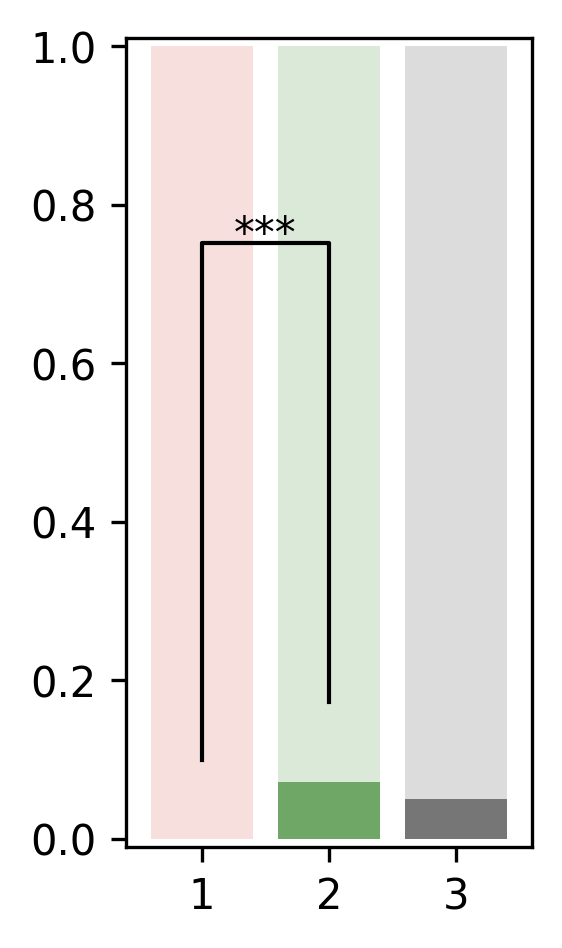

In [18]:
# bar plot of all clusters

bar_width = 0.8
colors = [red, darkgreen, darkgray]

nr = 1
nc = 1
ss_nr = 3.5
ss_nc = 7/4
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

bar_pos = np.array([1,2,3])
rp_proportion = []
# cluster 0-2
rp_proportion.append(np.sum(np.logical_or.reduce([rp_label_all==0, rp_label_all==1, rp_label_all==2]))/np.sum(np.logical_or.reduce([label_all==0, label_all==1, label_all==2])))
# cluster 3-4
rp_proportion.append(np.sum(np.logical_or.reduce([rp_label_all==3, rp_label_all==4]))/np.sum(np.logical_or.reduce([label_all==3, label_all==4])))
# other than 3-4,-1
rp_proportion.append(np.sum(np.logical_or.reduce([rp_label_all==3, rp_label_all==4, rp_label_all==-1]))/np.sum(np.logical_or.reduce([label_all==3, label_all==4, label_all==-1])))
rp_proportion = np.array(rp_proportion)
print(rp_proportion)
nonrp_proportion = 1-rp_proportion

bars_low = ax.bar(bar_pos, rp_proportion, 
                  width = bar_width,
                  color=colors, alpha=0.8)
bars_upper = ax.bar(bar_pos, nonrp_proportion, 
                    width = bar_width,
                    bottom=rp_proportion, color=colors, alpha=0.2)

ax.set_xlim(0.4,3.6)
ax.set_ylim(-0.01, 1.01)
ax.set_xticks(bar_pos, bar_pos)

# pv
hgap_big = 0.4
hgap_small = 0.01
hgap_txt = 0.1
for j, p in enumerate(p21[:]):
    x1 = 1
    x2 = x1+1
    bar1_max = rp_proportion[0] 
    bar2_max = rp_proportion[1] 
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_txt, bar12_max+hgap_big*1.7, bar12_max+hgap_big*1.7, bar2_max+hgap_txt],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big*1.7+hgap_small, sig_symb(p), ha='center', va='center')
    
# pv
hgap_big = 0.3
hgap_small = 0.01
hgap_txt = 0.1
for j, p in enumerate(p13[:]):
    x1 = 1
    x2 = x1+2
    bar1_max = rp_proportion[0]
    bar2_max = rp_proportion[2]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_txt, bar12_max+hgap_big*2, bar12_max+hgap_big*2, bar2_max+hgap_txt],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big*2+hgap_small, sig_symb(p), ha='center', va='center')

# plt.savefig(f'figs/fig_RP_all.pdf', dpi=300, bbox_inches='tight')